In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import matplotlib.pyplot as plt
#import torch
from modelling_fctns import double_logistic, normalized_difference
import data_cleaning
import LSP

import libtlda.tca

#import adapt.feature_based

import cv2
from PIL import Image

import scipy.signal
from scipy.interpolate import make_smoothing_spline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#

In [27]:
def cross_percentile_date(smoothed_series, percentile):
    # Calculate the 90th percentile
    percentile_value = np.percentile(smoothed_series, percentile)
    # Identify when the time series crosses the 90th percentile
    crosses_percentile_up = (smoothed_series > percentile_value).astype(int).diff().fillna(0) == 1#.astype(bool)
    crosses_percentile_down = (smoothed_series > percentile_value).astype(int).diff().fillna(0) == -1
    # Extract the dates when the crossing occurs
    crossing_dates_up = smoothed_series.index[crosses_percentile_up]
    crossing_dates_down = smoothed_series.index[crosses_percentile_down]
    return *crossing_dates_up, *crossing_dates_down

def double_logistic_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    params, _ = scipy.optimize.curve_fit(modelling_fctns.double_logistic, Times/365, values, maxfev = 10000)
    smoothed_series = pd.Series(modelling_fctns.double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def spline_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    spl = make_smoothing_spline(Times/365, values, lam = 0.00001)
    smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
    #print(Tighter_times/365, smoothed_series.idxmax(), smoothed_series)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    print(spl(Tighter_times[np.int64(smoothed_series.idxmax()*365)]/365), max_green, spl(Tighter_times/365).max())
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def savgol_LSP(values, Times, first_date, window_length=50, polyorder=2):
    print(len(values))
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)[1:-1]
    smoothed_derivs = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder,  deriv=1), index=Times)[1:-1]
    mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
    maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
    minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
    maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
    #percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0], 'D')
    #percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0], 'D')
    if len(cross_percentile_date(smoothed_series, 50)) < 2:
        percentile_50a = first_date - pd.Timedelta(9999, 'D')
        percentile_50b = first_date - pd.Timedelta(9999, 'D')
    else:
        percentile_50a = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0], 'D')
        percentile_50b = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[-1], 'D')
    if len(cross_percentile_date(smoothed_series, 90)) < 2:
        percentile_90a = first_date - pd.Timedelta(9999, 'D')
        percentile_90b = first_date - pd.Timedelta(9999, 'D')
    else:
        percentile_90a = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0], 'D')
        percentile_90b = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[-1], 'D')
    return mingrad, maxgrad, minday, maxday, percentile_50a, percentile_50b, percentile_90a, percentile_90b

def variable_percentiles(values, Times, first_date, window_length=50, polyorder=2):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)[1:-1]
    last_hits = []
    sl_hits = []
    for percentile in range(100):
        percentile_dates = cross_percentile_date(smoothed_series, percentile)
        if percentile_dates[-1] < percentile_dates[0]:
            print(percentile, percentile_dates)
        if len(percentile_dates) < 2:
            last_hits.append(first_date - pd.Timedelta(9999, 'D'))
            sl_hits.append(first_date - pd.Timedelta(9999, 'D'))
        elif len(percentile_dates) < 4:
            sl_hits.append(first_date + pd.Timedelta(percentile_dates[0], 'D'))#-2
            last_hits.append(first_date + pd.Timedelta(percentile_dates[-1], 'D'))#-1
        else:
            sl_hits.append(first_date + pd.Timedelta(percentile_dates[0], 'D'))#-2
            last_hits.append(first_date + pd.Timedelta(percentile_dates[-1], 'D'))#-1
    return *sl_hits, *last_hits
    
def variable_thresholds(values, Times, first_date, threshold_percentages = np.arange(0, 1, 0.05), smooth = True, window_length=4, polyorder=2):
    LSP_SOS_index = scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0)[:(len(values)//4)].argmin()
    restricted_values = scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0)#values[LSP_SOS_index:]
    restricted_Times = Times#[LSP_SOS_index:]
    minvalue = restricted_values.min()
    maxvalue = restricted_values.max()
    thresholds = minvalue + (maxvalue - minvalue)*threshold_percentages
    cummax = np.maximum.accumulate(restricted_values)
    cummax_reversed = np.maximum.accumulate(np.flip(restricted_values))
    first_cross_dates = first_date + pd.to_timedelta(restricted_Times[np.digitize(thresholds, cummax)], 'D')
    last_cross_dates = first_date + pd.to_timedelta(np.flip(restricted_Times)[np.digitize(thresholds, cummax_reversed)], 'D')
    print(*first_cross_dates, *last_cross_dates)
    return *first_cross_dates, *last_cross_dates

def savgol_raw(values, Times, first_date, window_length=50, polyorder=2):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)
    return first_date, *smoothed_series.values

def initialize_LSP_frame(LSP_method, MVI_window = 8, threshold_percentages = np.arange(0, 1, 0.05), Africa=False):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'percentile_10', 'percentile_50', 'percentile_90', 'percentile_10_2nd', 'max_green'])
    elif LSP_method == 'savgol':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'])
    elif LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw': # MVI_window*stepnum
        if Africa:
            results = pd.DataFrame(columns = ['year', 'Stations_Id'] + ['Day of start'] + ['NDVI interpolated at day ' + str(MVI_window*stepnum) for stepnum in range(int(35*8/MVI_window))])
        else:
            results = pd.DataFrame(columns = ['year', 'Stations_Id'] + ['Day of start'] + ['NDVI interpolated at day ' + str(MVI_window*stepnum) for stepnum in range(int(35*8/MVI_window))])
        #else:
        #    numsteps = int((200 - (MVI_window - (90 % MVI_window)))//MVI_window) + 1
        #    first_day = np.datetime64(f'2021-01-01') + np.timedelta64(89 + (MVI_window - (89 % MVI_window)), 'D')#np.datetime64('2021-04-07') 
        #    results = pd.DataFrame(columns = ['year', 'Stations_Id'] + ['NDVI interpolated at day ' + str((first_day+ np.timedelta64(MVI_window*stepnum, 'D')).item().strftime('%m.%d')) for stepnum in range(numsteps)])
    elif LSP_method == 'variable_thresholds':
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + [f'first time crossing threshold {int(np.round(threshold*100))}%' for threshold in threshold_percentages] + [f'last time crossing threshold {int(np.round(threshold*100))}%' for threshold in threshold_percentages])
    elif LSP_method == 'variable_percentiles':
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + [f'first time crossing percentile {int(np.round(threshold*100))}%' for threshold in threshold_percentages] + [f'last time crossing percentile {int(np.round(threshold*100))}%' for threshold in threshold_percentages])
    elif LSP_method == 'linterp_raw':
        results = pd.DataFrame(columns = ['year', 'Stations_Id'] + [f'linterp day {day}' for day in range(200)])
    return results

def append_LSP_frame(results, LSPs):
    results.loc[-1] = LSPs
    results.index = results.index + 1
    results = results.sort_index()
    return results

def calculate_append_LSP_frame(results, values, Times, first_date, LSP_method, year, station, threshold_percentages = np.arange(0, 1, 0.05), 
                                observed_anthesis = None, Times_for_plot = None):
    #print(len(results.columns), len(values))# 
    #print(results.columns)
    #print(LSP_method, 'function used')
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        if LSP_method == 'double_logistic':
            LSPs = double_logistic_LSP(values, Times, first_date)
        else:
            LSPs = spline_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol':
        LSPs = savgol_LSP(values, Times, first_date, window_length=8, polyorder=2)#14
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol_raw':
        LSPs = savgol_raw(values, Times, first_date, window_length=7, polyorder=2)
        if Times_for_plot is not None:
            smoothed_values = scipy.signal.savgol_filter(values, window_length=7, polyorder=2, deriv=0)
            if smoothed_values[0] < 0.1:
                print(values)
            fig, ax = plt.subplots()
            ax.plot(Times_for_plot, smoothed_values)
            ax.axvline(observed_anthesis)
            ax.set_title(f'Station: {station}, year: {year}')
        #print(LSPs)
        results = append_LSP_frame(results, [year, station, *LSPs])#np.min(LSPs.index), 
    elif LSP_method == 'variable_thresholds':
        LSPs = variable_thresholds(values, Times,first_date, threshold_percentages = threshold_percentages)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'variable_percentiles':
        LSPs = variable_percentiles(values, Times,first_date, window_length=14, polyorder=2)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'linterp_raw':
        #print(results, values)
        #print(len(results), len(values))
        results = append_LSP_frame(results, [year, station, *values])
    elif LSP_method == 'MVI_raw':
        results = append_LSP_frame(results, [year, station, np.min(Times), *values])
    return results

def LSP_at_stations(ds, start_year, end_year, 
                    LSP_method = 'double_logistic', interp_method = 'linear', 
                    MVI_window = 8, threshold_percentages = np.arange(0, 1, 0.05), 
                    buffer = 20, data_type = 'dwd', phen_data = None, Africa=False, plot_count = 0):
    results = initialize_LSP_frame(LSP_method, MVI_window = MVI_window, threshold_percentages = threshold_percentages, Africa=Africa)
    for year in range(start_year, end_year + 1):
        print(f'Year: {year}')
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[ds['Stations_Id'] == station]
            if data_type == 'dwd':
                ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0], buffer = buffer)
            else:
                ds_station.loc[:, 'date'] = pd.to_datetime(ds_station.loc[:, 'date'])#, format='%Y-%m-%d-%H-%M-%S')
                try:
                    SOS_date = phen_data.loc[(phen_data['Stations_id'] == station) & (phen_data['Referenzjahr'] == year)]['WC SOS date'].values[0]
                    print(SOS_date, year)
                except:
                    print('WC SOS not available')
                    continue
                ds_station_year = ds_station.loc[(ds_station['date'] >= SOS_date) & (ds_station['date'] < SOS_date + np.timedelta64(200 + buffer, 'D'))]# - np.timedelta64(buffer, 'D')
            try:
                anthesis_date = phen_data.loc[(phen_data['Stations_id'] == station) & (phen_data['Referenzjahr'] == year)]['observed time to beginning of flowering'].values[0]
                print(anthesis_date)
            except:
                anthesis_date = None
                print('WC SOS not available')
            if anthesis_date != None:
                if data_type == 'dwd':
                    anthesis_date = pd.Timestamp(f'{year}-01-01') + pd.Timedelta(ds_station['SOS'].iloc[0], 'D') + pd.to_timedelta(anthesis_date)
                else:
                    anthesis_date = pd.to_datetime(anthesis_date)
            #print(ds_station_year['date'].min(), ds_station_year['date'].max())
            #if len(ds_station_year) > 7:
            #    print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            if len(ds_station_year) <= 30:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations so ignored')
                continue
            #try:
            if interp_method == 'linear':
                if LSP_method == 'linterp_raw':
                    jan1_rows = ds_station_year.iloc[[0, 1]].copy()
                    jan1_rows.loc[:, 'date'] = np.array([np.datetime64(f'{year}-01-01'), np.datetime64(f'{year}-12-31')])
                    jan1_rows.loc[:, 'NDVI'] = 0.1
                    jan1_rows.loc[:, 'sur_refl_b01'] = 0
                    jan1_rows.loc[:, 'sur_refl_b02'] = 0
                    jan1_rows = jan1_rows.rename(index={jan1_rows.index[0]: 0, jan1_rows.index[1]: 1})
                    ds_station_year = pd.concat([ds_station_year, jan1_rows.rename(index={jan1_rows.index[0]: 0, jan1_rows.index[1]: 1})], ignore_index=True, axis = 0).sort_values('date')
                    #print(ds_station_year)
                ds_interpolated = data_cleaning.resample_linear(ds_station_year)
                days = pd.to_datetime(ds_interpolated['time']).dt.dayofyear
                #print(days)
                ds_interpolated = ds_interpolated.where((days > 90)*(days <=290)).dropna(how='all')
            elif interp_method == 'MVI':
                if LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw':
                    jan1_row = ds_station_year.iloc[0].copy()
                    jan1_row.loc['date'] = np.datetime64(f'{year}-01-01')
                    jan1_row.loc['NDVI'] = 0
                    jan1_row.loc['sur_refl_b01'] = 0
                    jan1_row.loc['sur_refl_b02'] = 0
                    ds_station_year = pd.concat([ds_station_year, jan1_row.rename(index=0).to_frame().T],ignore_index=True, axis = 0).sort_values('date')
                    #print(ds_station_year['date'])
                    ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=MVI_window) #data_cleaning.
                    ds_interpolated = ds_interpolated.set_index(['time']).resample(f'{MVI_window}D').interpolate().reset_index()
                    if data_type == 'dwd':
                        days = pd.to_datetime(ds_interpolated['time']).dt.dayofyear 
                        #print('Length of frame: ', len(ds_interpolated))
                        #ds_interpolated = ds_interpolated.loc[pd.to_datetime(ds_interpolated['time']) > ]
                        ds_interpolated = ds_interpolated.where((days > ds_station['SOS'].iloc[0] - 60)*(days < ds_station['SOS'].iloc[0] + 240)).dropna(how='all') #90, 290
                        #ds_interpolated = ds_interpolated.resample(f'{MVI_window}D').interpolate()
                        #print(ds_interpolated['time'])
                    else:
                        ds_interpolated = ds_interpolated.loc[(ds_interpolated['time'] >= SOS_date)]
                else:
                    ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=MVI_window)
            #except:
            #    print(f'Couldn\'t interpolate station {station} in year {year}')
            #    continue
            ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
            #print(ds_interpolated)
            Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
            NDVIs = ds_interpolated['NDVI'].values
            if (LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw'):
                if Africa:
                    numsteps = int(35*8/MVI_window)
                else:
                    numsteps = int(35*8/MVI_window)
                if len(ds_interpolated) < numsteps:
                    print('Length of frame: ', len(ds_interpolated))
                    print('too short')
                    continue
                Times = Times[:numsteps]
                NDVIs = NDVIs[:numsteps]
            first_date = ds_interpolated['time'].min()
            if LSP_method == 'savgol_raw' or LSP_method == 'MVI_raw':
                if len(NDVIs) != results.shape[1] - 3:
                    print(len(NDVIs), results.shape[1])
                    continue
            #try:
            if anthesis_date != None and plot_count < 10:
                print(plot_count)
                results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station, threshold_percentages=threshold_percentages, observed_anthesis=anthesis_date, Times_for_plot=ds_interpolated['time'].values[:numsteps])
                plot_count += 1
            else:
                results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station, threshold_percentages=threshold_percentages, Times_for_plot = None)
            #except:
                #print(f'Couldn\'t compute LSP for station {station} in year {year}')
                #continue
    return results, ds_interpolated

def prepare_obs_for_LSP(ds, instrument='MODIS'):
    if instrument == 'MODIS':
        ds = ds.where(ds['sur_refl_b01'] != -9999).dropna()
        ds = ds.where(ds['reducer'] == 'mean').dropna()
        #ds['NDVI'] = ( ds['sur_refl_b02'] - ds['sur_refl_b01'] ) / ( ds['sur_refl_b02'] + ds['sur_refl_b01'] )
        ds['date'] = pd.to_datetime(ds['date'])
        ds['year'] = ds['date'].dt.year
        ds = data_cleaning.add_EOS_to_df(ds)
        ds = data_cleaning.add_SOS_to_df(ds)
    return ds

def get_LSPs(start_year, end_year, LSP_method = 'double_logistic', 
                interp_method = 'linear', instrument='MODIS', 
                last_index = 1200, step = 40, file_path = 'MODIS\\Germany\\satdata', 
                MVI_window = 8, threshold_percentages = np.arange(0, 1, 0.05),
                buffer = 20, separate_year_files = True, data_type = 'dwd', 
                phen_data = None, Africa=False):
    for first_in_file in np.arange(0, last_index, step):
        if separate_year_files:
            ds_list = []
            print(f'Station {first_in_file}')
            for year in range(start_year, end_year + 1):
                ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}{first_in_file}_{year}.csv')) #Sentinel
            ds = pd.concat(ds_list, axis = 0)
        else:
            ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}{first_in_file}.csv')
        #try:
        #    ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}\\satdata{first_in_file}_{year}.csv')
        #except:
        #    print(f'File {first_in_file} year {year} failed to load')
        #    continue
        ds = prepare_obs_for_LSP(ds, instrument)
        if first_in_file == 0:
            LSP_times, ds_interpolated = LSP_at_stations(ds, start_year, end_year, LSP_method, interp_method, MVI_window=MVI_window, threshold_percentages = threshold_percentages, buffer = buffer, data_type = data_type, phen_data=phen_data, Africa=Africa, plot_count = 0)
        else:
            LSP_times = pd.concat([LSP_times, LSP_at_stations(ds, start_year, end_year,
                                                                LSP_method, interp_method, 
                                                                MVI_window=MVI_window, 
                                                                threshold_percentages = threshold_percentages, 
                                                                buffer = buffer, data_type = data_type, 
                                                                phen_data = phen_data,
                                                                Africa=Africa, plot_count = 11)[0]], axis=0)
    return LSP_times

def WC_SOS_CIMMYT(lat, lon, phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')):
    EOS_SOS = phen_data_CIMMYT.loc[(phen_data_CIMMYT['lat'] == lat) & (phen_data_CIMMYT['lon'] == lon)][['SOS', 'EOS']].values[0]
    return EOS_SOS[0]

In [3]:
def add_SOS_EOS_to_df_CIMMYT(df, phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')):
    df['SOS'] = -999
    df['EOS'] = -999
    lat_prev = 1000
    lon_prev = 1000
    for index in df.index:
        lat = df.loc[index]['lat']
        lon = df.loc[index]['lon']
        if lat_prev != lat or lon_prev != lon:
            SOS = WC_SOS_CIMMYT(lat, lon, phen_data_CIMMYT)
            EOS = WC_EOS_CIMMYT(lat, lon, phen_data_CIMMYT)
            lat_prev = lat
            lon_prev = lon
            print(lat, lon)
        #print(phen_data_CIMMYT.loc[index]['lat'])
        df.loc[index, 'SOS'] = SOS
        df.loc[index, 'EOS'] = EOS
    return df

def add_EOS_to_df(df):
    df['EOS'] = WC_EOS(df['lon'], df['lat'])
    return df

def WC_date_from_columns(ds, phase):
    #### yrcode must be the year of the observation ####
    ds.loc[:, 'WC SOS date'] = pd.to_datetime(ds.loc[:, 'yrcode'], format = '%Y') + pd.to_timedelta(ds['SOS'], 'D')
    wrong_year = ((ds[f'observed time to {phase}'] - ds['WC SOS date']).dt.days < 0)
    ds.loc[wrong_year, 'WC SOS date'] = ds.loc[wrong_year, 'WC SOS date'] - np.timedelta64(365, 'D')
    out_of_season = ((ds[f'observed time to {phase}'] - ds['WC SOS date']).dt.days > 170) & (ds['SOS2'] > 0)
    ds.loc[out_of_season, 'WC SOS date'] = pd.to_datetime(ds.loc[:, 'yrcode'], format = '%Y') + pd.to_timedelta(ds['SOS2'], 'D')
    wrong_year = ((ds[f'observed time to {phase}'] - ds['WC SOS date']).dt.days < 0)
    ds.loc[out_of_season & wrong_year, 'WC SOS date'] = ds.loc[out_of_season & wrong_year, 'WC SOS date'] - np.timedelta64(365, 'D')
    ds = ds.rename(columns={'yrcode': 'Referenzjahr'})
    return ds

In [4]:
def prepare_African_phen_ds(ds, phase):
    ds['yrcode'] = ds[f'observed time to {phase}'].dt.year
    columns_to_keep = ['lat', 'lon', 'Stations_id', f'observed time to {phase}', 'yrcode', 'SOS', 'EOS', 'SOS2', 'EOS2']
    if np.isin('PlantingDate', ds.columns):
        print('yes')
        columns_to_keep.append('PlantingDate')
    ds = ds[columns_to_keep].groupby(['Stations_id', 'yrcode', 'lat', 'lon']).mean().reset_index()
    ds = WC_date_from_columns(ds, phase)
    return ds

In [5]:
phen_data_TZ = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_TZ.csv')
phen_data_TZ = data_cleaning.columns_to_datetime(phen_data_TZ, ['flowering date', 'emergence date', 'maturity date'])
phen_data_TZ = phen_data_TZ.rename(columns={'station': 'Stations_id', 'flowering date': 'observed time to beginning of flowering'})
phen_data_TZ = prepare_African_phen_ds(phen_data_TZ, 'beginning of flowering')

phen_data_ET = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\TAMASA_ET.csv')
phen_data_ET = data_cleaning.columns_to_datetime(phen_data_ET, ['flowering date', 'emergence date', 'maturity date'])
phen_data_ET = phen_data_ET.rename(columns={'Site no. = EXPsit': 'Stations_id', 'flowering date': 'observed time to beginning of flowering'})
phen_data_ET = prepare_African_phen_ds(phen_data_ET, 'beginning of flowering')


In [40]:
phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
phen_data_CIMMYT = data_cleaning.columns_to_datetime(phen_data_CIMMYT, ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
phen_data_CIMMYT = phen_data_CIMMYT.rename(columns={'AnthesisDate': 'observed time to beginning of flowering'})
phen_data_CIMMYT = prepare_African_phen_ds(phen_data_CIMMYT, 'beginning of flowering')#'PlantingDate', 
phen_data_CIMMYT = phen_data_CIMMYT.loc[(phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['WC SOS date']).dt.days < 240]
phen_data_CIMMYT['WC SOS date'] = phen_data_CIMMYT['PlantingDate']
phen_data_CIMMYT['Referenzjahr'] = phen_data_CIMMYT['WC SOS date'].dt.year

yes


In [23]:
LSP_frame_savgol.rename(columns={'year':'Referenzjahr', 'Stations_Id': 'Stations_id'}, inplace=True)
LSP_frame_savgol.merge(phen_data_CIMMYT, on=['Referenzjahr', 'Stations_id'])

,Referenzjahr,Stations_id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,NDVI interpolated at day 48,...,NDVI interpolated at day 152,lat,lon,observed time to beginning of flowering,SOS,EOS,SOS2,EOS2,PlantingDate,WC SOS date


In [45]:
ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
ds_t2m = ds_t2m.drop(['Unnamed: 0'] + [f't2m at day {n}' for n in range(200)], axis = 1)
ds_t2m = ds_t2m.dropna(subset = ['observed time to beginning of flowering'])

Year: 1999
WC SOS not available
1999-11-10T00:00:00.000000000 1999
2000-02-10T22:48:00.000000000
0
WC SOS not available
WC SOS not available
1999-01-12T00:00:00.000000000 1999
1999-03-13T10:32:34.285714304
Station 1042.0 in 1999 has 0 observations so ignored
WC SOS not available
1999-12-05T22:24:00.000000000 1999
2000-02-14T03:40:48.000000000
1
WC SOS not available
1999-12-06T01:36:00.000000000 1999
2000-02-15T16:38:24.000000000
2
WC SOS not available
Year: 2000
WC SOS not available
2000-11-30T00:00:00.000000000 2000
2001-02-14T03:05:27.272727296
3
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
2000-11-22T20:08:19.684542592 2000
2001-02-03T02:40:21.198738304
4
WC SOS not available
2000-12-13T17:54:37.611940352 2000
2001-02-24T18:27:56.417910400
5
2000-11-14T00:00:00.000000000 2000
2001-01-29T01:36:00.000000000
6
Year: 2001
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC

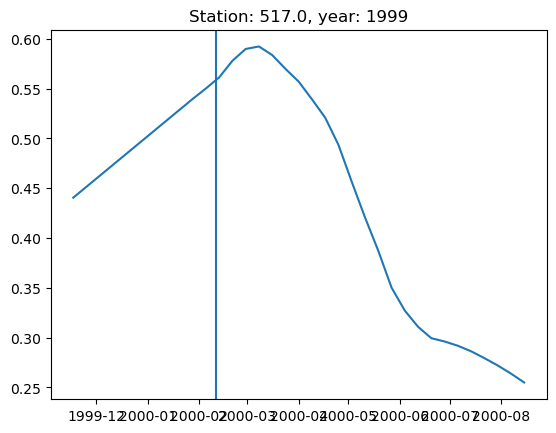

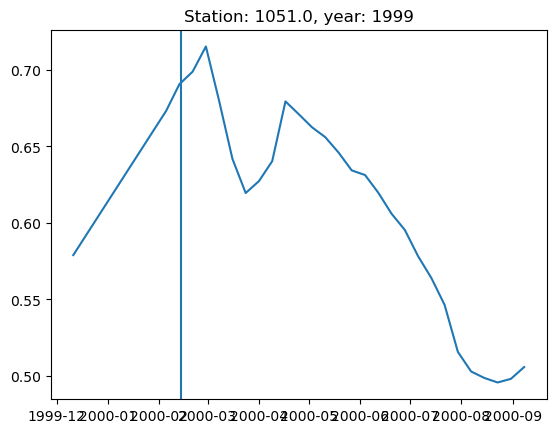

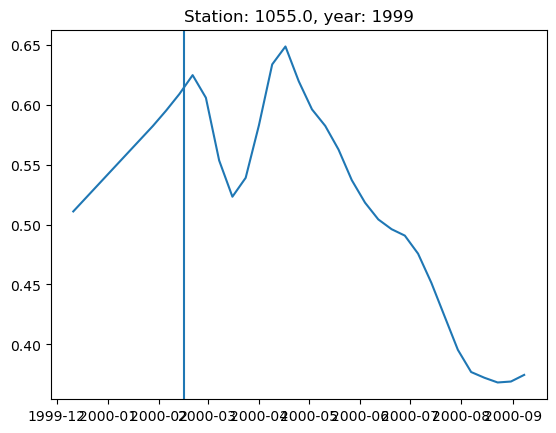

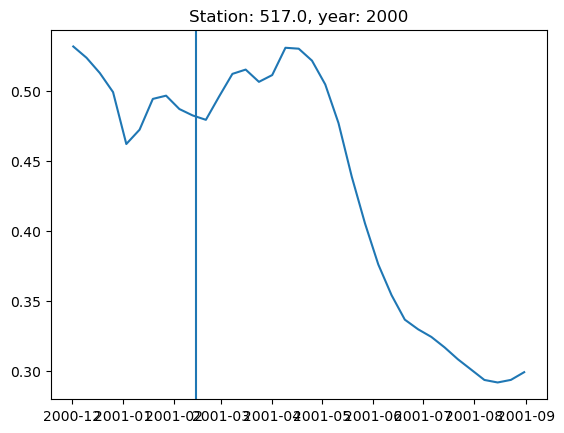

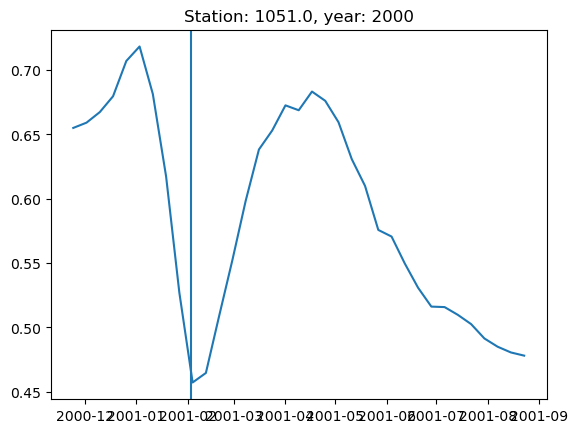

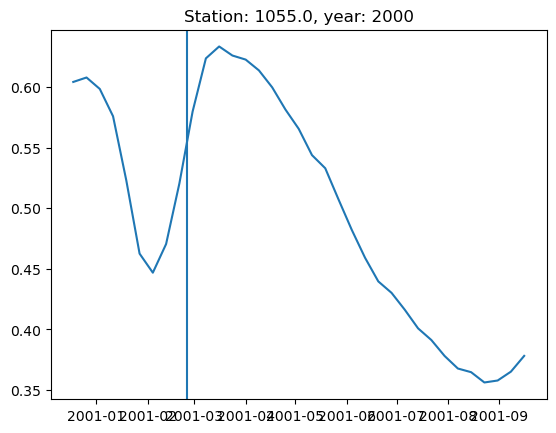

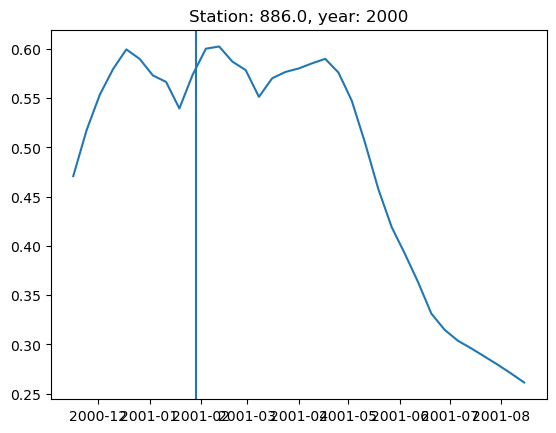

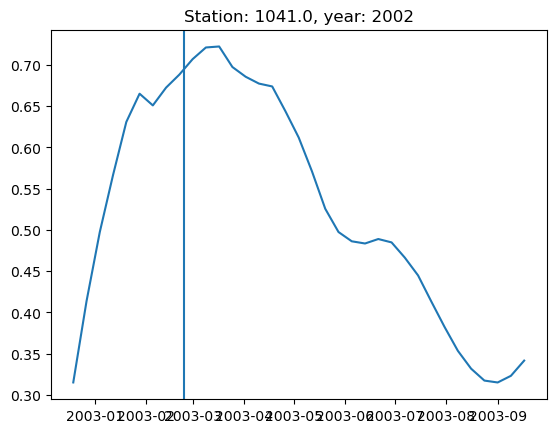

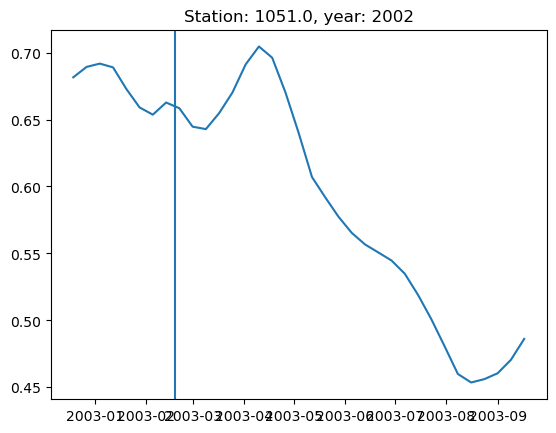

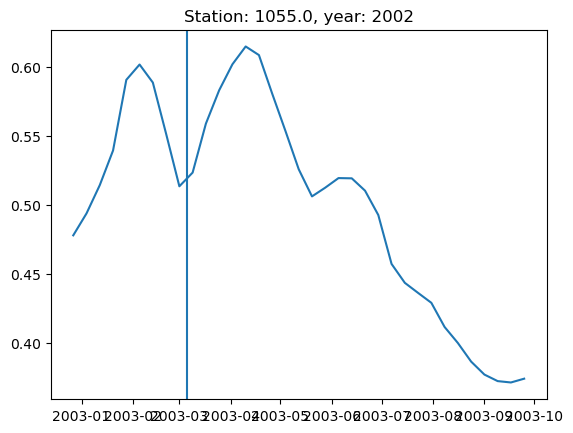

In [43]:
LSP_frame_savgol = get_LSPs(1999, 2009, LSP_method = 'savgol_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=110, step=10, file_path='MODIS\\Kenya\\averages\\CIMMYT_averaged', 
                    separate_year_files = False,
                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 120, phen_data = phen_data_CIMMYT, data_type = 'CIMMYT_averaged', 
                    Africa=True)#1204
LSP_frame_savgol.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_MODIS_SSA_PD_SOS.csv')

In [44]:
len(LSP_frame_savgol)

241

Year: 1999
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
1999-03-13T10:32:34.285714304
Station 1042.0 in 1999 has 0 observations so ignored
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
Year: 2000
WC SOS not available
2000-02-10T22:48:00.000000000
Length of frame:  25
too short
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
2000-02-14T03:40:48.000000000
Length of frame:  34
too short
WC SOS not available
2000-02-15T16:38:24.000000000
Length of frame:  32
too short
WC SOS not available
Year: 2001
WC SOS not available
2001-02-14T03:05:27.272727296
0
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
2001-02-03T02:40:21.198738304
1
WC SOS not available
2001-02-24T18:27:56.417910400
2
2001-01-29T01:36:00.000000000
3
Year: 2002
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not avail

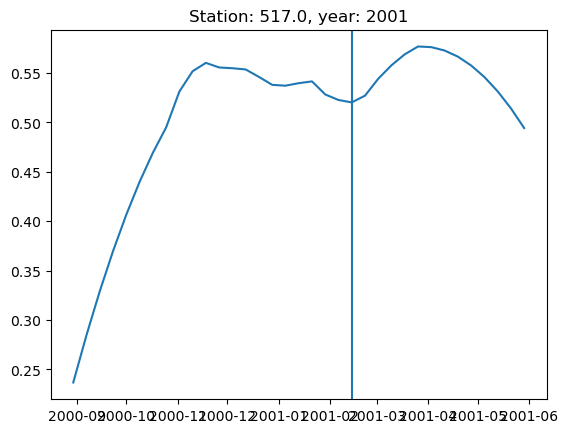

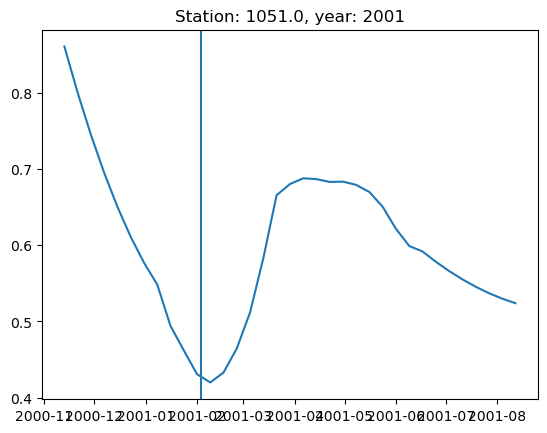

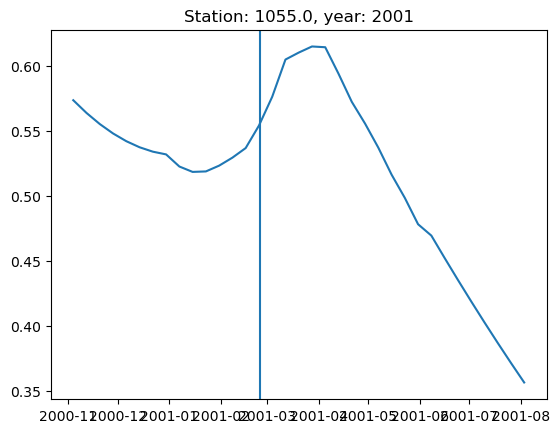

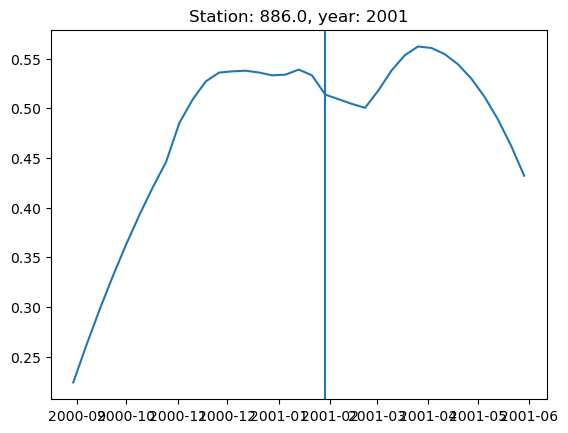

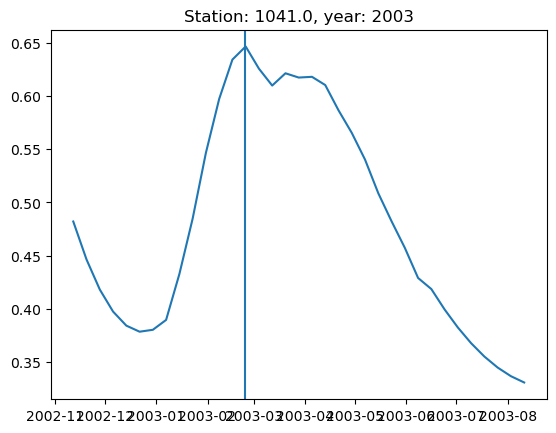

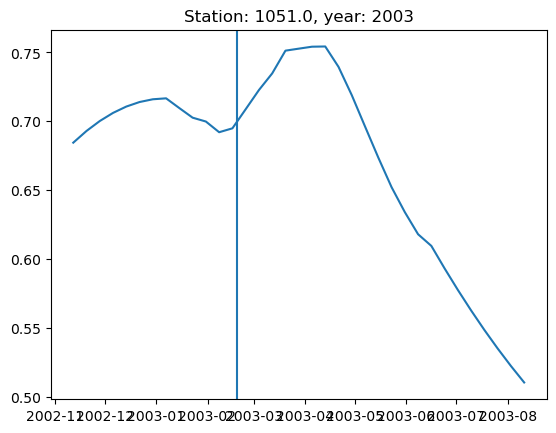

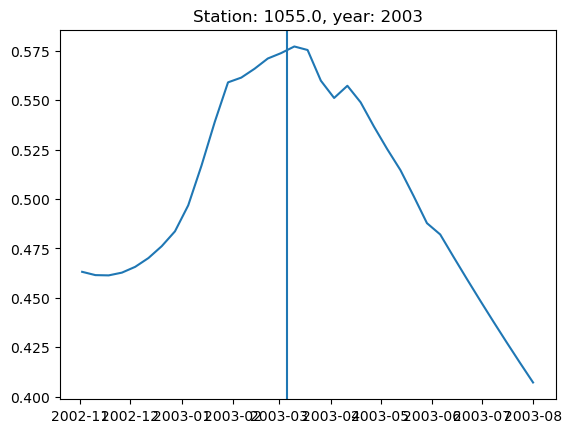

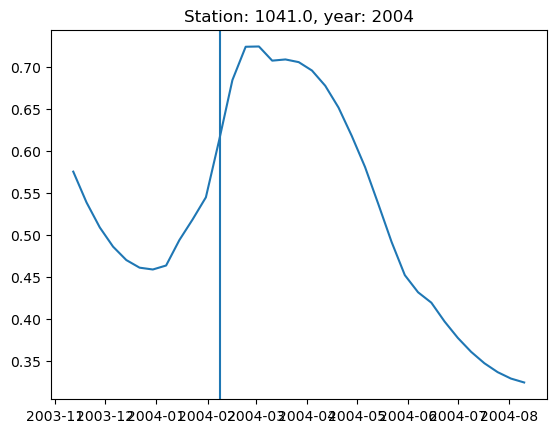

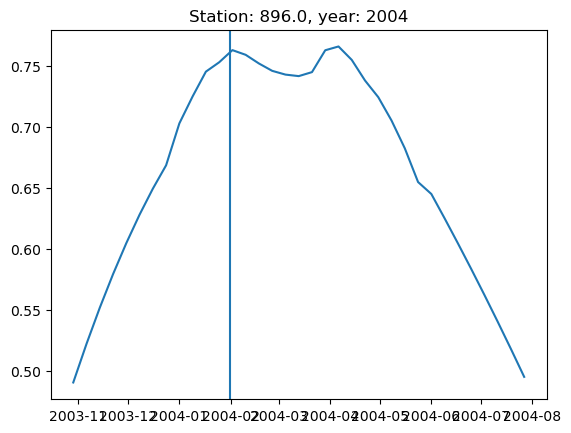

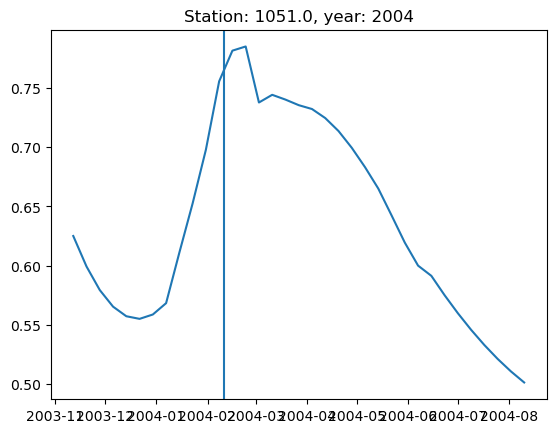

In [8]:
LSP_frame_savgol = get_LSPs(1999, 2009, LSP_method = 'savgol_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=110, step=10, file_path='MODIS\\Kenya\\pixels\\CIMMYT_one_pixel_with_SOS_', 
                    separate_year_files = False,
                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 120, phen_data = phen_data_CIMMYT, data_type = 'CIMMYT', 
                    Africa=True)#1204
LSP_frame_savgol.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_MODIS_SSA_WC_SOS.csv')

Year: 1999
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
1999-12-17T23:44:34.285714304
0
WC SOS not available
WC SOS not available
Year: 2000
WC SOS not available
WC SOS not available
WC SOS not available
2000-08-20T17:14:24.000000000
1
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
2000-07-27T22:57:00.000000000
2
WC SOS not available
Year: 2001
2001-02-18T00:28:48.000000000
Station 524.0 in 2001 has 27 observations so ignored
WC SOS not available
2001-02-02T21:28:17.142857088
3
2001-06-18T10:26:39.195979904
4
2001-03-03T02:42:46.956521728
5
WC SOS not available
2001-03-23T16:48:00.000000000
6
2001-02-20T03:26:10.909090944
7
2001-04-17T02:05:29.832402176
8
WC SOS not available
Year: 2002
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not available
WC SOS not availab

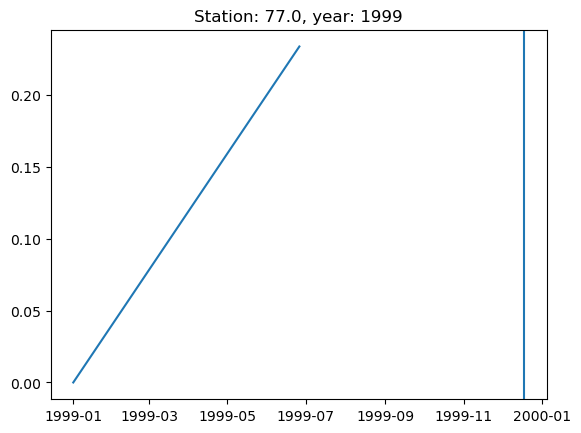

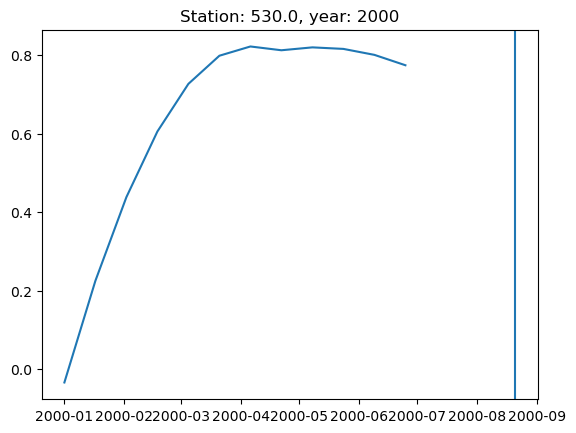

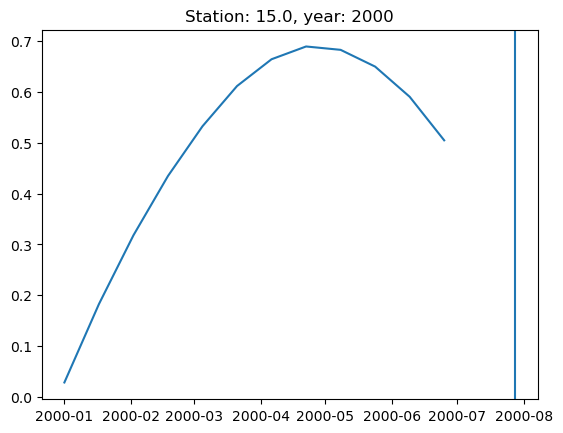

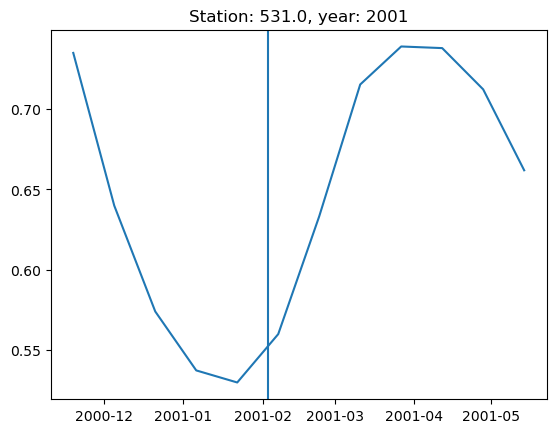

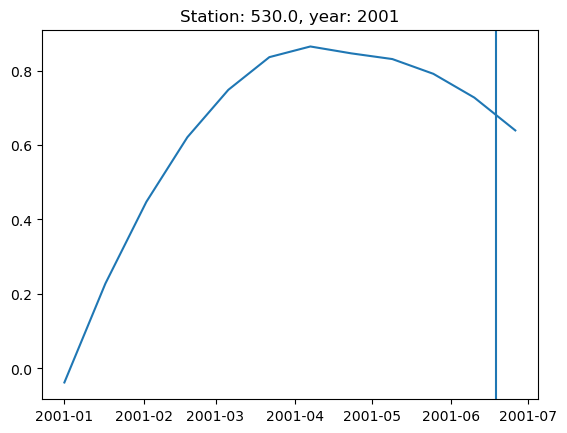

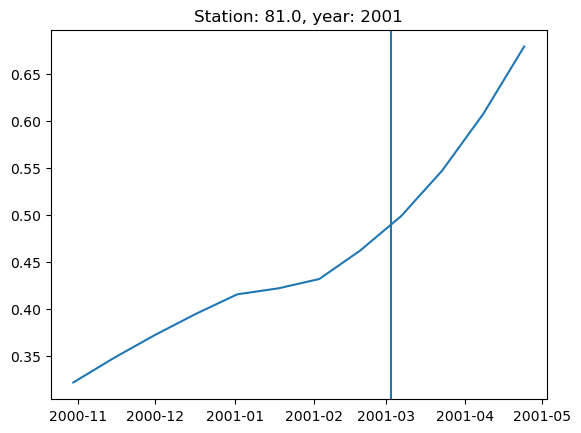

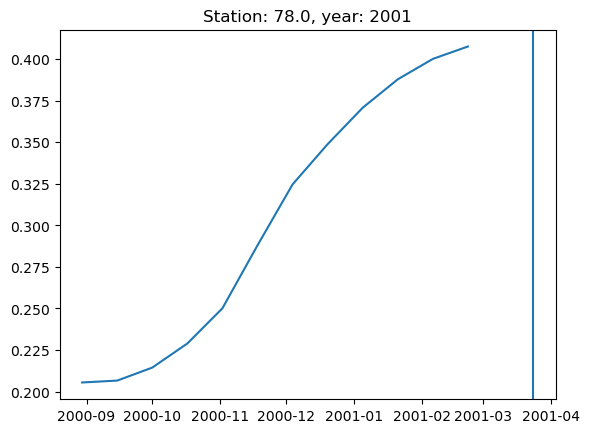

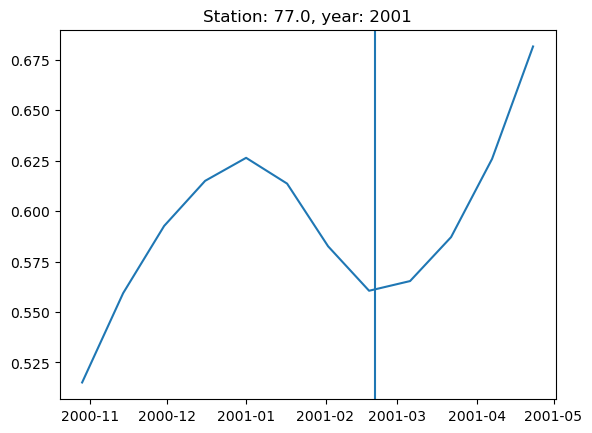

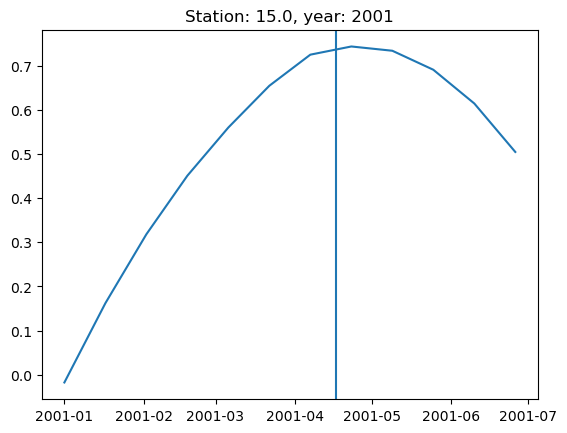

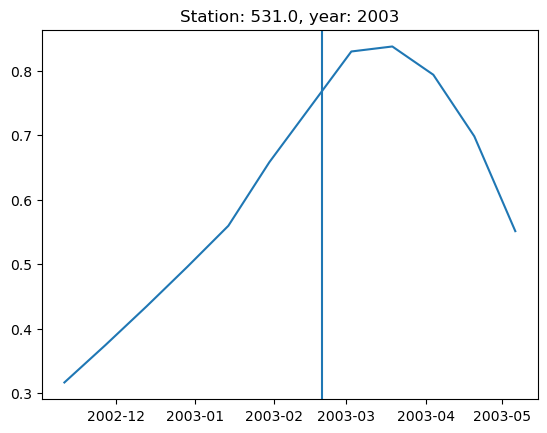

In [23]:
LSP_frame_savgol = get_LSPs(1999, 2009, LSP_method = 'savgol_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=110, step=10, file_path='MODIS\\Kenya\\CIMMYT_one_pixel_with_SOS_', 
                    separate_year_files = False,
                    MVI_window= 16, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 120, phen_data = phen_data_CIMMYT, data_type = 'CIMMYT', 
                    Africa=True)#1204
#LSP_frame_savgol.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_MODIS_SSA_WC_SOS.csv')

In [90]:
LSP_frame_savgol = get_LSPs(1999, 2009, LSP_method = 'MVI_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=110, step=10, file_path='MODIS\\Kenya\\CIMMYT_one_pixel_with_SOS_', 
                    separate_year_files = False,
                    MVI_window= 4, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 20, phen_data = phen_data_CIMMYT,
                    Africa=True)#1204
LSP_frame_savgol.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_MVI_raw_MODIS_SSA_WC_SOS.csv')

Year: 1999
Station 1041.0 in 1999 has 0 observations so ignored
Station 517.0 in 1999 has 0 observations so ignored
Station 513.0 in 1999 has 0 observations so ignored
Station 896.0 in 1999 has 0 observations so ignored
Station 1042.0 in 1999 has 0 observations so ignored
Station 1056.0 in 1999 has 0 observations so ignored
Station 1051.0 in 1999 has 0 observations so ignored
Station 1067.0 in 1999 has 0 observations so ignored
Station 1055.0 in 1999 has 0 observations so ignored
Station 886.0 in 1999 has 0 observations so ignored
Year: 2000
Length of frame:  16
Length of frame:  10
10 14
Length of frame:  11
11 14
Length of frame:  14
Length of frame:  16
Station 1056.0 in 2000 has 29 observations so ignored
Length of frame:  16
Length of frame:  14
Length of frame:  15
Length of frame:  10
10 14
Year: 2001
Length of frame:  16
Length of frame:  11
11 14
Length of frame:  11
11 14
Length of frame:  15
Length of frame:  16
Length of frame:  15
Length of frame:  16
Length of frame:  14


In [ ]:
file_path = 'MODIS\\Kenya\\CIMMYT_one_pixel'
for first_in_file in range(0, 110, 10):
    ds_MODIS = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}{first_in_file}.csv')
    ds_MODIS2 = add_SOS_EOS_to_df_CIMMYT(ds_MODIS)#.where((ds_MODIS['NDVI'] >0) & (ds_MODIS['reducer'] == 'mean')).dropna())
    ds_MODIS2.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\{file_path}_with_SOS_{first_in_file}.csv')

In [9]:
#LSP_frame_linterp = get_LSPs(2017, 2022, LSP_method = 'linterp_raw', 
#                    interp_method = 'linear', instrument='MODIS', 
#                    last_index=1204, file_path='MODIS\\Germany3', 
#                    MVI_window= 4, threshold_percentages = np.arange(0, 1, 0.01),
#                    buffer = 80)#1204

#LSP_frame_linterp.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_linterp_MODIS_DE.csv')

In [10]:
#LSP_frame_MVI = get_LSPs(2017, 2022, LSP_method = 'MVI_raw', 
#                    interp_method = 'MVI', instrument='MODIS', 
#                    last_index=1204, file_path='MODIS\\Germany3', 
#                    MVI_window= 4, threshold_percentages = np.arange(0, 1, 0.01),
#                    buffer = 80)#1204
#LSP_frame_MVI.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_MVI_MODIS_DE.csv')

Station 0
Year: 2017
WC SOS not available
110 days
0
105 days
1
WC SOS not available
112 days
2
99 days
3
106 days
4
115 days
5
128 days
6
104 days
7
WC SOS not available
101 days
8
100 days
9
107 days
97 days
98 days
102 days
93 days
99 days
105 days
WC SOS not available
106 days
95 days
83 days
90 days
107 days
94 days
94 days
WC SOS not available
100 days
88 days
103 days
97 days
96 days
101 days
110 days
93 days
102 days
WC SOS not available
Station 8015.0 in 2017 has 0 observations so ignored
WC SOS not available
Station 8053.0 in 2017 has 0 observations so ignored
Year: 2018
94 days
96 days
89 days
WC SOS not available
100 days
95 days
115 days
99 days
92 days
86 days
WC SOS not available
90 days
96 days
84 days
100 days
89 days
100 days
94 days
Station 7910.0 in 2018 has 0 observations so ignored
102 days
89 days
94 days
95 days
86 days
77 days
87 days
95 days
92 days
85 days
WC SOS not available
87 days
91 days
102 days
93 days
86 days
92 days
99 days
94 days
91 days
WC SOS not

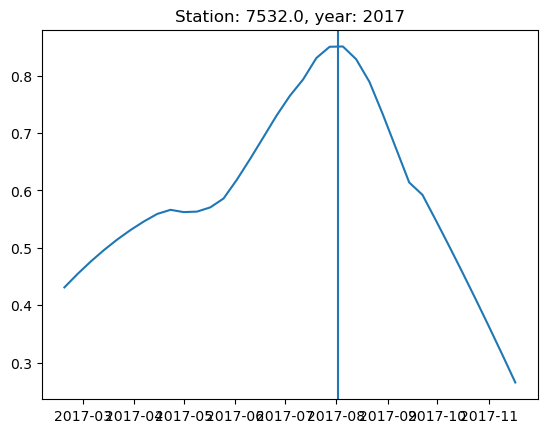

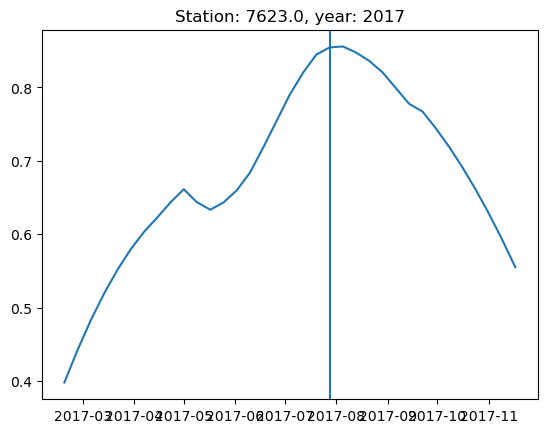

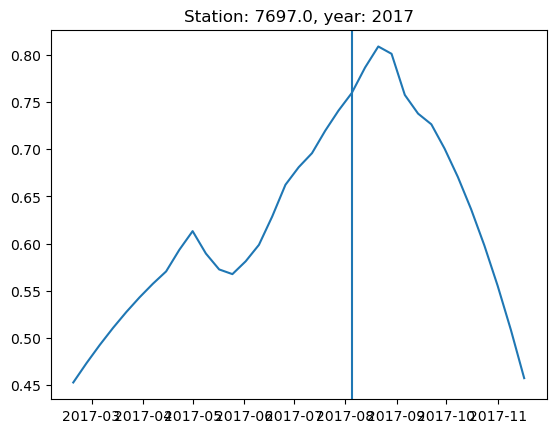

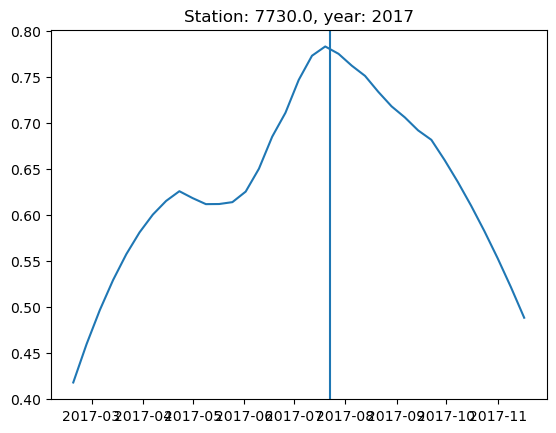

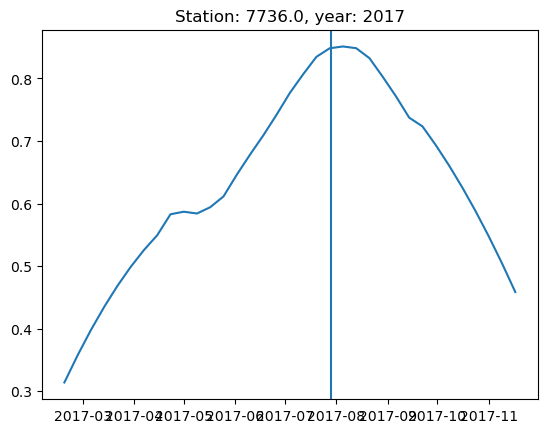

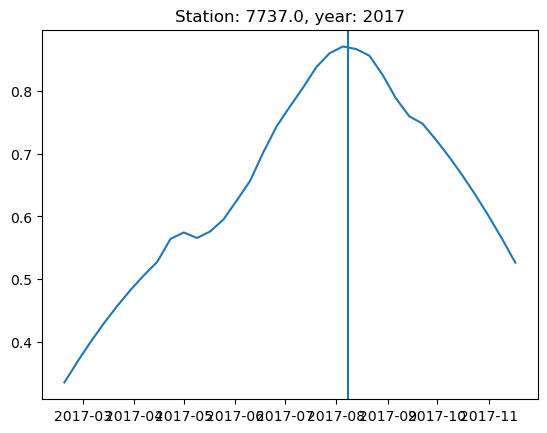

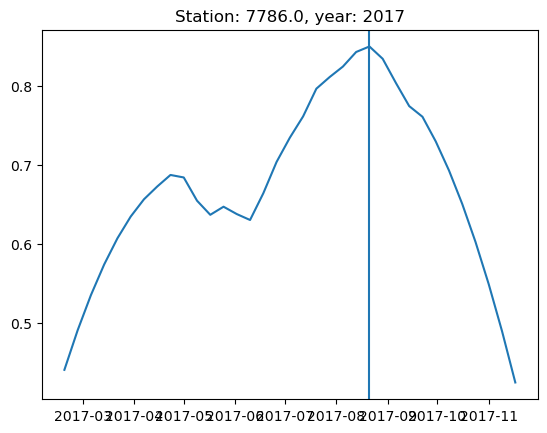

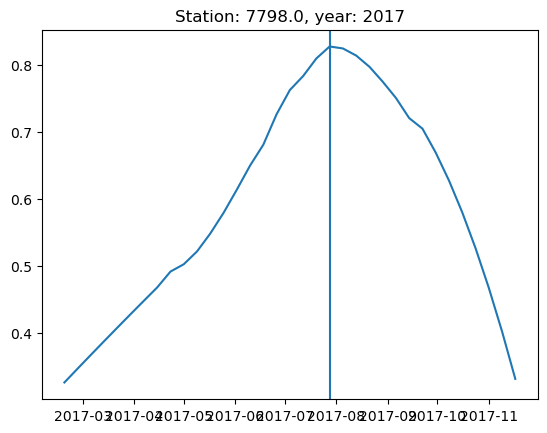

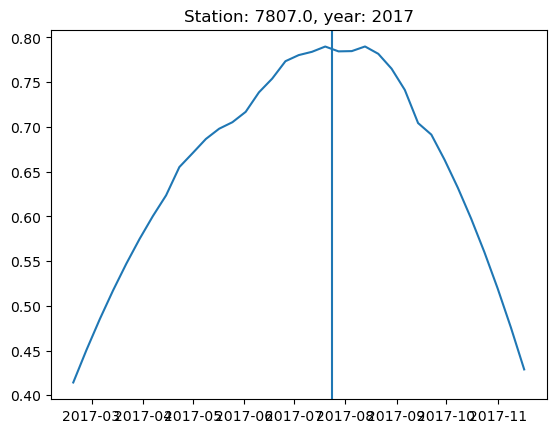

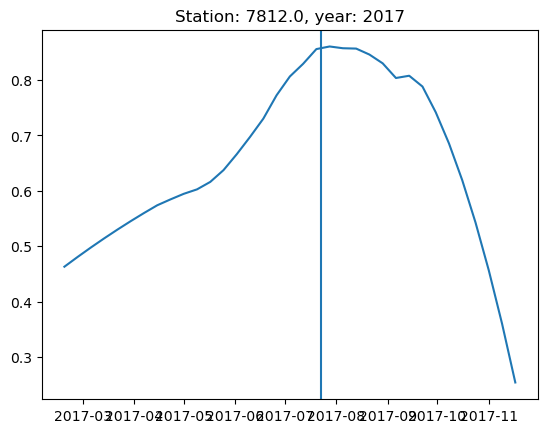

In [49]:
LSP_frame_savgol_raw = get_LSPs(2017, 2022, LSP_method = 'savgol_raw', 
                    interp_method = 'MVI', instrument='MODIS', 
                    last_index=1204, step=40, file_path='MODIS\\Germany3\\satdata', separate_year_files = True,
                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
                    buffer = 60, phen_data=ds_t2m)#1204
LSP_frame_savgol_raw.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_60_offset.csv')

In [73]:
LSP_frame_savgol_raw

,year,Stations_Id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 4,NDVI interpolated at day 8,NDVI interpolated at day 12,NDVI interpolated at day 16,NDVI interpolated at day 20,NDVI interpolated at day 24,...,NDVI interpolated at day 160,NDVI interpolated at day 164,NDVI interpolated at day 168,NDVI interpolated at day 172,NDVI interpolated at day 176,NDVI interpolated at day 180,NDVI interpolated at day 184,NDVI interpolated at day 188,NDVI interpolated at day 192,NDVI interpolated at day 196
0,2022,8015.0,2022-04-03,0.659746,0.658269,0.643827,0.616422,0.576052,0.505431,0.420843,...,0.599666,0.569387,0.534016,0.485751,0.454660,0.430710,0.413269,0.400543,0.392532,0.389236
1,2022,8348.0,2022-04-03,0.405241,0.417892,0.429048,0.438710,0.446877,0.455565,0.444357,...,0.885951,0.762971,0.604747,0.475302,0.392207,0.391914,0.389971,0.420674,0.484023,0.580019
2,2022,8333.0,2022-04-03,0.523892,0.543364,0.557073,0.565021,0.567206,0.560362,0.553184,...,0.640617,0.556645,0.453385,0.403249,0.380352,0.383170,0.398254,0.436840,0.498928,0.584517
3,2022,8304.0,2022-04-03,0.431871,0.499557,0.553059,0.592375,0.617506,0.621337,0.616895,...,0.665793,0.660257,0.652866,0.661806,0.644539,0.622826,0.595661,0.555542,0.502470,0.436443
4,2022,8301.0,2022-04-03,0.403614,0.480432,0.540490,0.583788,0.610327,0.619221,0.588834,...,0.556872,0.489360,0.476047,0.481620,0.502848,0.530448,0.539069,0.539918,0.532995,0.518301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,13930.0,2017-04-03,0.495607,0.506302,0.515444,0.523032,0.529066,0.536325,0.532211,...,0.683046,0.669777,0.646721,0.634459,0.626211,0.625429,0.614064,0.600695,0.585322,0.567945
182,2017,13929.0,2017-04-03,0.518711,0.487494,0.465620,0.453089,0.449901,0.448343,0.489759,...,0.661940,0.643426,0.594647,0.509575,0.449020,0.412296,0.411688,0.435997,0.485223,0.559367
183,2017,13928.0,2017-04-03,0.682414,0.695396,0.705663,0.713214,0.718049,0.721358,0.707394,...,0.637315,0.645992,0.654432,0.699424,0.724005,0.691014,0.676762,0.657845,0.634260,0.606009
184,2017,13927.0,2017-04-03,0.627931,0.653568,0.666302,0.666130,0.653055,0.617123,0.573732,...,0.790625,0.774536,0.777602,0.716930,0.616561,0.526948,0.486537,0.461254,0.451100,0.456074


In [12]:
#LSP_frame_MVI = get_LSPs(2017, 2022, LSP_method = 'savgol', 
#                    interp_method = 'MVI', instrument='MODIS', 
#                    last_index=1204, file_path='MODIS\\Germany3', 
#                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
#                    buffer = 20)#1204
#LSP_frame_MVI.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_MODIS_DE.csv')

In [13]:
#LSP_frame = get_LSPs(2017, 2022, LSP_method = 'variable_percentiles', 
#                    interp_method = 'MVI', instrument='MODIS', 
#                    last_index=1204, file_path='MODIS\\Germany3', 
#                    MVI_window= 8, threshold_percentages = np.arange(0, 1, 0.01),
#                    buffer = 20)#1204

In [22]:
#LSP_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_savgol.csv')
#LSP_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_thresholds_dates.csv')
LSP_frame.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_varied_percentiles3.csv')

In [7]:
def plot_two_NDVI_curves(ds, index_1, index_2, year, font_size = 15, interp_method = 'linear', window_length=50, polyorder=2, variable_name = 'NDVI', save = False): #shift = 0, 
    fig, axs = plt.subplots(2, 1, figsize = (5, 6))
    for plot_index, obs_index in enumerate([index_1, index_2]):
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[obs_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
        ds_interpolated = data_cleaning.resample_linear(ds_year)
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        NDVIs = ds_interpolated[variable_name].values
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        axs[plot_index].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
        axs[plot_index].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
        savgol_dates = savgol_LSP(NDVIs, Times, first_date, window_length=window_length)
        axs[plot_index].axvline(x = savgol_dates[1], color='r', label = 'Maximum gradient of smoothed curve')
        axs[plot_index].axvline(x = savgol_dates[0], color='b', linestyle='--', label = 'Minimum gradient of smoothed curve')
        axs[plot_index].axvline(x = savgol_dates[5], color='r', linestyle=':', label = 'last 75th percentile crossing')
        axs[plot_index].axvline(x = savgol_dates[4], color='r', linestyle='--', label = 'second last 75th percentile crossing')
        calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
        axs[plot_index].axvline(x = calendar_SOS, color='k', linestyle='--', label = 'SOS from worldcereal')
        axs[plot_index].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[plot_index].tick_params(labelrotation=45)
        axs[plot_index].set_title(f'location {plot_index + 1}', fontsize = font_size)
    axs[1].set_xlabel('Day of Year', fontsize = font_size)
    
    fig.suptitle('Year of Sentinel-2 NDVI data at 2 locations in Germany', fontsize = font_size)
    fig.tight_layout(w_pad=9)
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.15, 0.5))
    if save:
        fig.savefig('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\plots\\two_NDVI_curves.png', bbox_inches='tight')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()


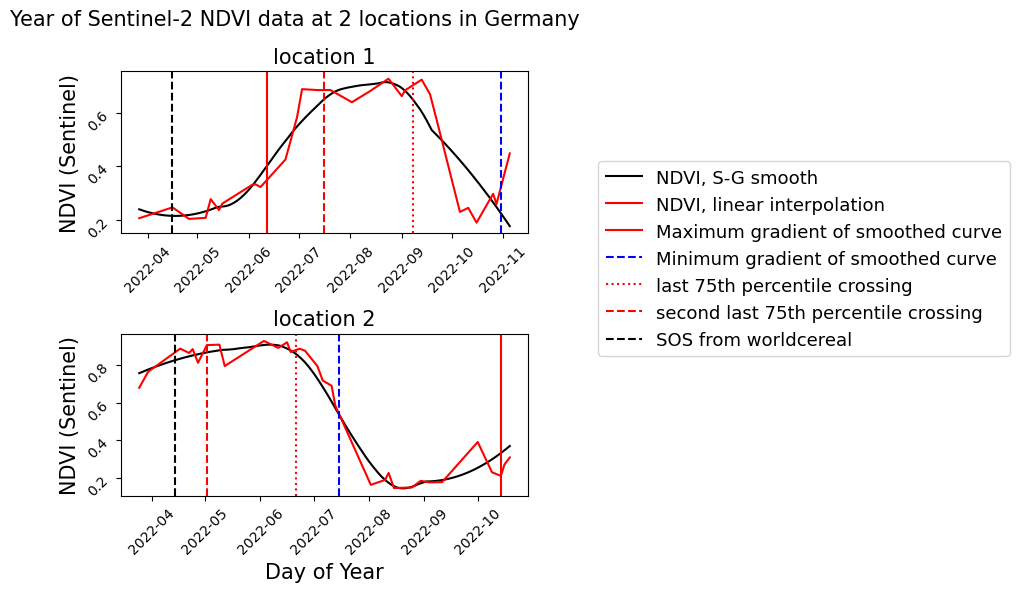

In [29]:
ds_list = []
for start_index in range(0, 25, 25):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{start_index}.csv'))
ds = pd.concat(ds_list, axis = 0)
#ds = pd.concat([ds1, ds2, ds3], axis = 0)
ds = ds.where(ds['NDVI'] != -9999).dropna()
ds = ds.where(ds['reducer'] == 'median').dropna()
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
ds['NDVI2'] = normalized_difference(ds['B8'], ds['B4'])
plot_two_NDVI_curves(ds, 8, 1, 2022, font_size = 15, window_length=95, variable_name='NDVI', save=True)

In [8]:
def plot_one_season(ds_interpolated, ax, calendar_SOS, font_size = 15,
                    window_length=50, polyorder=2, 
                    variable_name = 'NDVI', data_type = 'dwd', obs_time = None):
    Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
    Tighter_times = np.arange(Times[0], Times[-1])
    NDVIs = ds_interpolated[variable_name].values
    first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
    ax.plot(first_date + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
    ax.plot(first_date + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
    #threshold_dates = variable_thresholds(NDVIs, Times, first_date, threshold_percentages = np.arange(0, 1, 0.1), smooth = True, window_length=window_length, polyorder=2)
    #print(threshold_dates)
    #threshold_dates = first_date + pd.to_timedelta(np.array([*threshold_dates]), 'D')
    savgol_dates = savgol_LSP(NDVIs, Times, first_date, window_length=window_length)
    ax.axvline(x = savgol_dates[3], color='r', linestyle=':', label = 'maxday')
    ax.axvline(x = savgol_dates[2], color='r', linestyle='--', label = 'minday')
    ax.axvline(x = savgol_dates[1], color='r', label = 'maxgrad')
    ax.axvline(x = savgol_dates[0], color='b', linestyle='--', label = 'mingrad')
    #ax.axvline(x = savgol_dates[5], color='r', linestyle=':', label = 'last 90th percentile hit')
    #ax.axvline(x = savgol_dates[4], color='r', linestyle='--', label = 'first 90th percentile hit')
    #ax.axvline(x = threshold_dates[1], color='r', linestyle='--', label = 'first 0.1 threshold hit')
    #ax.axvline(x = threshold_dates[5], color='b', linestyle='--', label = 'first 0.5 threshold hit')
    #ax.axvline(x = threshold_dates[9], color='g', linestyle='--', label = 'first 0.9 threshold hit')
    #ax.axvline(x = threshold_dates[11], color='r', linestyle=':', label = 'last 0.1 threshold hit')
    #ax.axvline(x = threshold_dates[15], color='b', linestyle=':', label = 'last 0.5 threshold hit')
    #ax.axvline(x = threshold_dates[19], color='g', linestyle=':', label = 'last 0.9 threshold hit')
    ax.axvline(x = calendar_SOS, color='k', linestyle='--', label = 'SOS from worldcereal')
    if obs_time != None:
        ax.axvline(x = obs_time, color='green', linestyle='--', label = 'observed anthesis')
    ax.set_xlabel('Day of Year', fontsize = font_size)
    ax.set_ylabel('NDVI (MODIS)', fontsize = font_size)
    ax.tick_params(labelrotation=45)
            

In [9]:
def plot_many_NDVI_curves(ds, year, font_size = 15, interp_method = 'linear', 
                            curve = 'double_logistic', window_length=50, 
                            polyorder=2, variable_name = 'NDVI', data_type = 'dwd',
                            phen_data = None): #shift = 0, 
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    location_index = 0
    #shift = 0
    failures = 0
    while location_index - failures < 10: #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        if data_type == 'dwd':
            ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
            calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
            observed_anthesis=None
        else:
            ds_station.loc[:, 'date'] = pd.to_datetime(ds_station.loc[:, 'date'])#, format='%Y-%m-%d-%H-%M-%S')
            #for test_year in range(1999, 2007):
            test_year = year
            print(test_year)
            try:
                calendar_SOS = phen_data.loc[(phen_data['lon'] == latlon['lon']) & (phen_data['lat'] == latlon['lat']) & (phen_data['Referenzjahr'] == test_year), 'WC SOS date'].values[0]
                #### Important - comment out when looking at dwd data ####
                observed_anthesis = phen_data.loc[(phen_data['lon'] == latlon['lon']) & (phen_data['lat'] == latlon['lat']) & (phen_data['Referenzjahr'] == test_year), 'observed time to beginning of flowering'].values[0]
            except:
                print('WC SOS not available')
                location_index += 1
                failures += 1
                continue
            ds_year = ds_station.loc[(ds_station['date'] >= calendar_SOS) & (ds_station['date'] < calendar_SOS + np.timedelta64(220, 'D'))]
        #try:
        print(len(ds_year))
        if interp_method == 'linear':
            ds_interpolated = data_cleaning.resample_linear(ds_year)
        elif interp_method == 'MVI':
            ds_interpolated = data_cleaning.max_value_int(ds_year, window_size=8) #data_cleaning.
            print(len(ds_year))
            if len(ds_year) <9:
                print('too short after interpolation')
                location_index += 1
                failures += 1
                continue
            ds_interpolated = ds_interpolated.rename(columns = {'date': 'raw_time'}).reset_index().rename(columns = {'date': 'time'})
            ds_interpolated['NDVI'] = np.interp(ds_interpolated['time'], ds_interpolated['raw_time'], ds_interpolated['NDVI'])
        print(location_index, latlon['lat'], latlon['lon'])
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        plot_one_season(ds_interpolated, axs[location_index - failures], calendar_SOS, font_size = 15,
                    window_length=window_length, polyorder=polyorder, 
                    variable_name = 'NDVI', data_type = 'dwd', obs_time = observed_anthesis)
        #try:
        #    observed_time_emergence_to_yellow_ripeness = pd.to_datetime(ds_year['emergence date'].iloc[0]) + pd.Timedelta(ds_year['observed time emergence to yellow ripeness'].iloc[0], 'D')
        #    axs[location_index - failures].axvline(x = observed_time_emergence_to_yellow_ripeness, color='green', linestyle=':', label = 'observed ripeness')
        #    axs[location_index - failures].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
        #except:
        #    print('no maturity data')
        location_index += 1
    fig.suptitle('Year of MODIS NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
    print(f'There were {failures} failures')
        

In [27]:
phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
phen_data_CIMMYT = data_cleaning.columns_to_datetime(phen_data_CIMMYT, ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
phen_data_CIMMYT = phen_data_CIMMYT.rename(columns={'AnthesisDate': 'observed time to beginning of flowering'})
phen_data_CIMMYT = prepare_African_phen_ds(phen_data_CIMMYT, 'beginning of flowering')#'PlantingDate', 
phen_data_CIMMYT = phen_data_CIMMYT.loc[(phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['WC SOS date']).dt.days < 240]

yes


2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
119
119
4 -15.03 13.43
28
2003
63
63
5 -8.9 14.7
21
2003
55
55
6 -8.91 14.73
19
2003
WC SOS not available
2003
70
70
8 -9.1 13.7
15
2003
WC SOS not available
2003
WC SOS not available
2003
148
148
11 -25.48 25.47
28
2003
WC SOS not available
2003
140
140
13 -23.03 26.517
25
2003
144
144
14 -24.57 25.95
28
2003
90
90
15 9.1 37.15
22
2003
111
111
16 8.4 39.33
26
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
79
79
31 -15.92 35.07
26
327.0
127.0
There were 22 failures
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not available
2003
WC SOS not avail

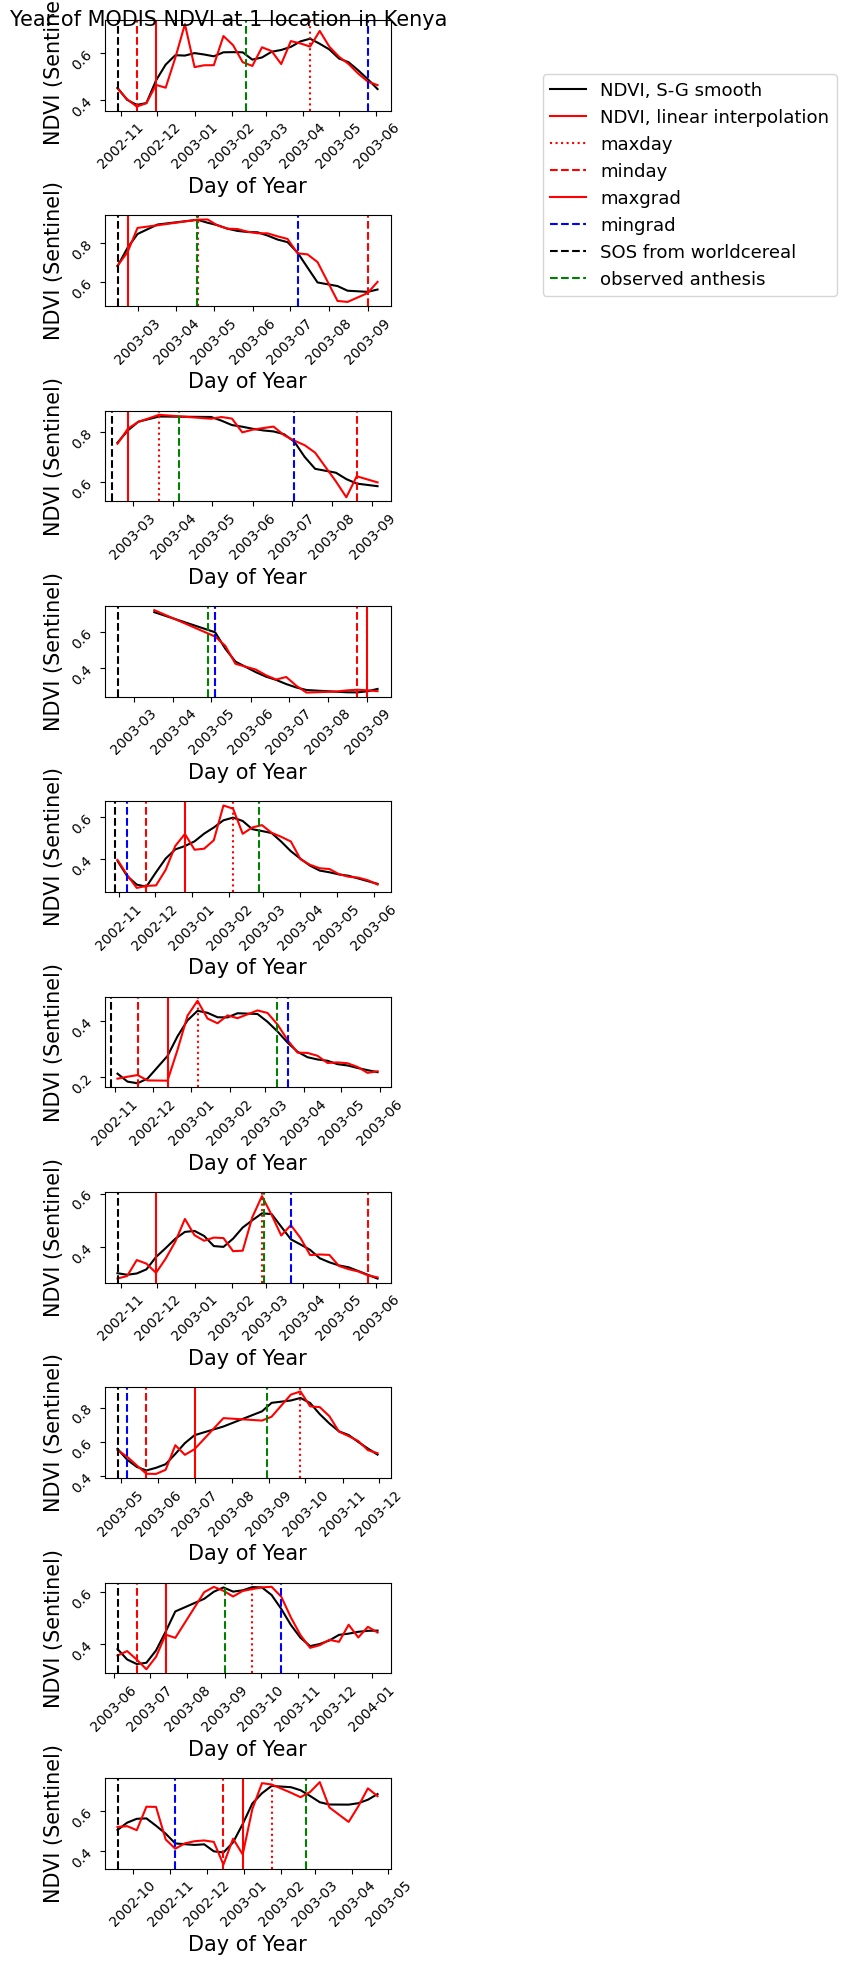

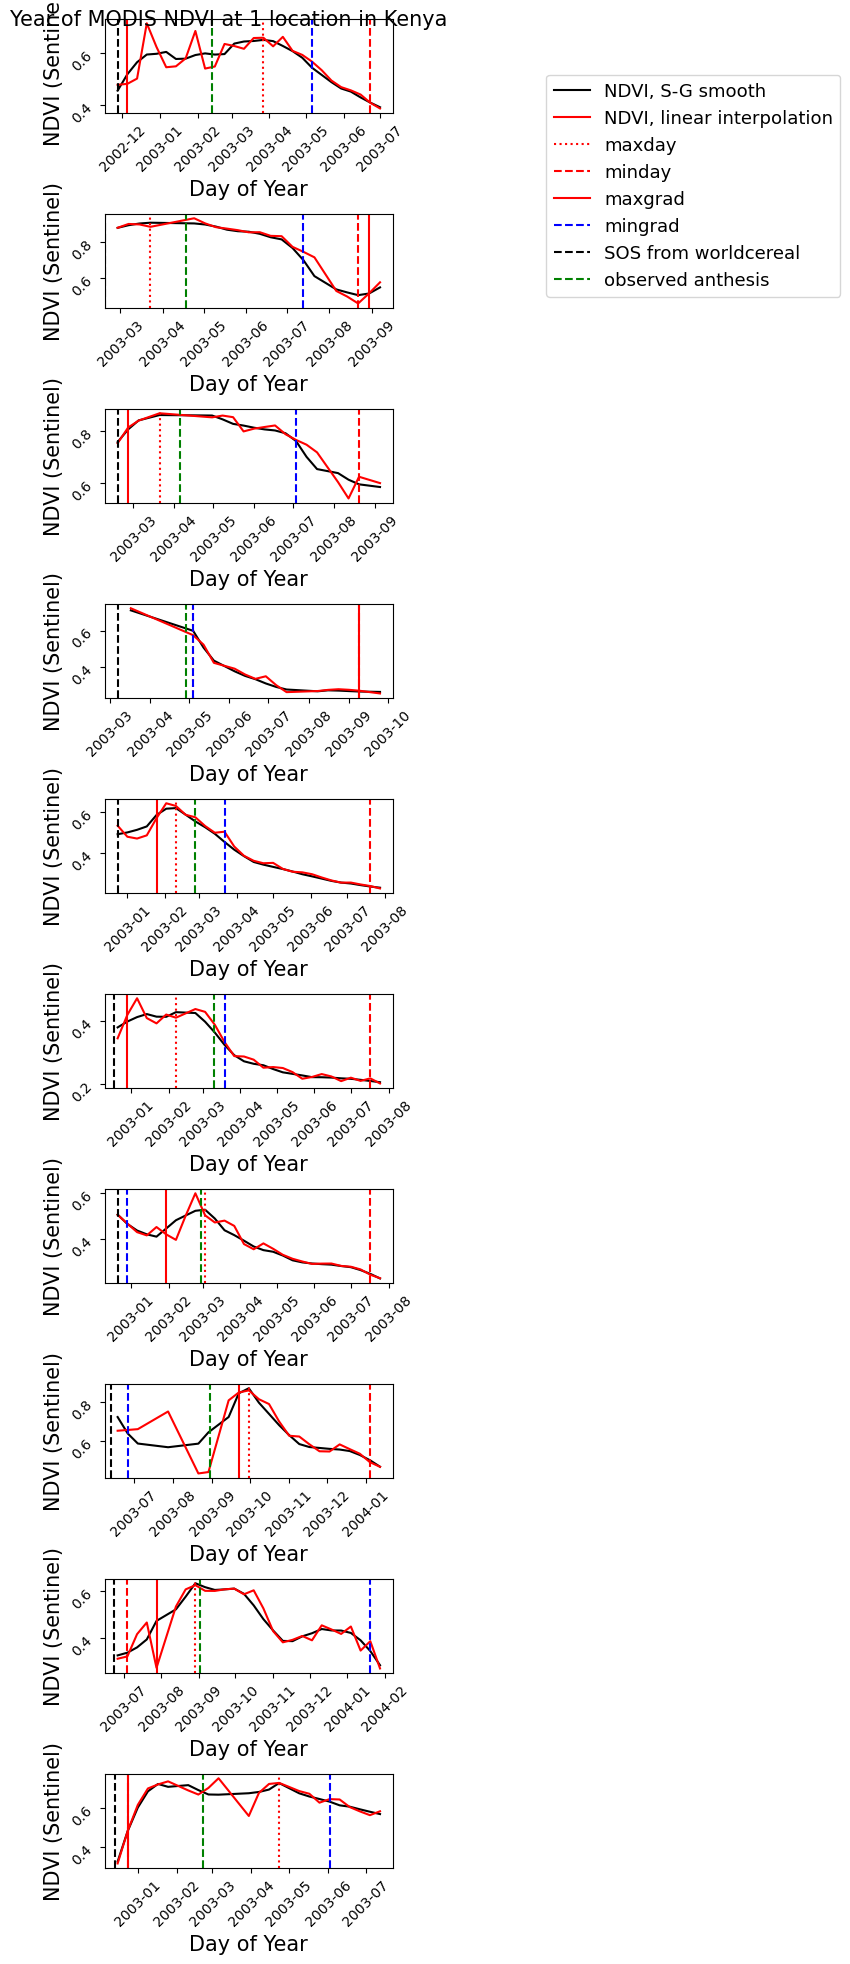

In [28]:
ds_list = []
for first_in_file in range(0, 110, 10):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\CIMMYT_one_pixel_with_SOS_{first_in_file}.csv'))
ds = pd.concat(ds_list, axis = 0)
ds = prepare_obs_for_LSP(ds, instrument='MODIS')[1:]
ds['NDVI'] = ds['NDVI']
obs_data = phen_data_CIMMYT.copy()
obs_data = obs_data.drop(columns=['lat', 'lon'])#'Unnamed: 0', 
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
plot_many_NDVI_curves(ds, 2003, font_size = 15, curve='spline', window_length=8, variable_name='NDVI', interp_method='MVI', data_type = 'CIMMYT', phen_data = phen_data_CIMMYT)
phen_data_CIMMYT['WC SOS date'] = phen_data_CIMMYT['PlantingDate']
plot_many_NDVI_curves(ds, 2003, font_size = 15, curve='spline', window_length=8, variable_name='NDVI', interp_method='MVI', data_type = 'CIMMYT', phen_data = phen_data_CIMMYT)

116
116
0 54.3167 10.05
29
139
139
1 54.4333 9.8167
29
109
109
2 54.4 8.7667
28
114
114
3 53.95 10.6833
28
114
114
4 54.7333 9.5667
29
134
134
5 54.7167 9.95
29
115
115
6 54.75 9.5167
27
84
84
7 53.6167 10.7
29
111
111
8 53.5 10.4833
29
125
125
9 54.6167 8.9667
28
103.0
296.0
There were 0 failures


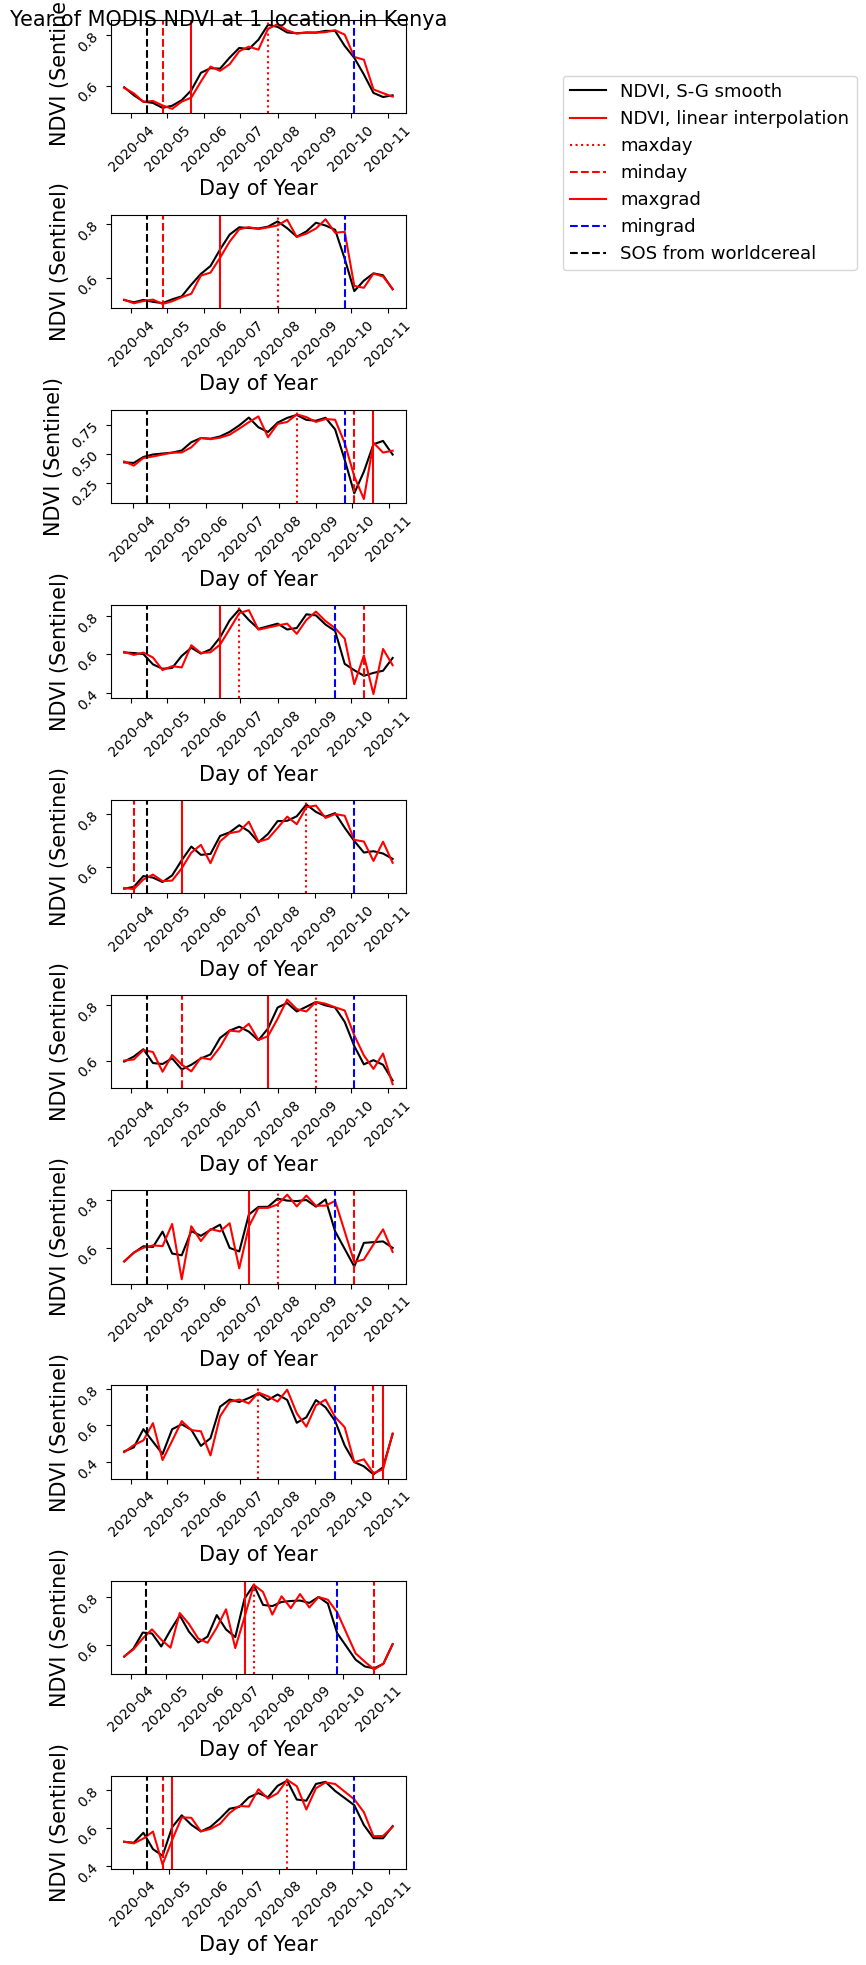

In [12]:
ds_list = []
for start_index in range(0, 1200, 40):
    for year in [2017, 2018, 2019, 2020, 2021, 2022]:
        ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany3\\satdata{start_index}_{year}.csv')) #Sentinel
ds = pd.concat(ds_list, axis = 0)
ds = prepare_obs_for_LSP(ds, instrument='MODIS')[1:]
ds['NDVI'] = ds['NDVI']
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
plot_many_NDVI_curves(ds, 2020, font_size = 15, window_length=4, variable_name='NDVI', interp_method='MVI')#curve='spline', 

In [8]:
def plot_long_NDVI_curves(ds, start_year, end_year, interp_method = 'linear', variable_name = 'NDVI', window_length=50, polyorder=2, font_size = 20):
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    location_index = 0
    #shift = 0
    failures = 0
    while location_index - failures < 10: #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        ds_year = ds_station.loc[(ds_station['year'] >= start_year) & (ds_station['year'] <= end_year)]
        try:
            if interp_method == 'linear':
                ds_interpolated = data_cleaning.resample_linear(ds_year)
            elif interp_method == 'MVI':
                ds_interpolated = data_cleaning.max_value_int(ds_year, window_size=8) #data_cleaning.
        except:
            print('Couldn\'t interpolate')
            failures += 1
            location_index += 1
            continue
        print(location_index, latlon['lat'], latlon['lon'])
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        #print(Times.shape, Tighter_times.shape)
        NDVIs = ds_interpolated[variable_name].values
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        if interp_method == 'linear':
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
            #smoothed_derivs = scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder,  deriv=1)
            #axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), smoothed_derivs, label = 'NDVI, S-G smooth', color = 'black')
        else:
            axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'Data')
            axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), NDVIs, label = 'Data', color = 'red')
        for year in range(start_year, end_year + 1):
            SOS = np.datetime64(f'{year}-01-01') + pd.to_timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
            EOS = np.datetime64(f'{year}-01-01') + pd.to_timedelta(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']), 'D')
            axs[location_index - failures].axvline(SOS, c = 'red', label = 'SOS')
            axs[location_index - failures].axvline(EOS, c = 'blue', label = 'EOS')
        axs[location_index - failures].set_xlabel('Day of Year', fontsize = font_size)
        axs[location_index - failures].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[location_index - failures].tick_params(labelrotation=45)
        location_index += 1
    fig.suptitle('7 years of Sentinel NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
    print(f'There were {failures} failures')

In [ ]:
ds_list = []
for start_index in range(0, 25, 25):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{start_index}.csv'))
ds = pd.concat(ds_list, axis = 0)
#ds = pd.concat([ds1, ds2, ds3], axis = 0)
ds = ds.where(ds['NDVI'] != -9999).dropna()
ds = ds.where(ds['reducer'] == 'median').dropna()
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
ds['NDVI2'] = normalized_difference(ds['B8'], ds['B4'])
plot_long_NDVI_curves(ds, 2019, 2022, font_size = 15, window_length=95, variable_name='NDVI2')